## Neural Network for Number Detection

### Downloading Dependencies

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

### For GPU Processing

In [116]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')            #cuda is a parallel processing platform for gpus, if available utilize that for faster comp
    else:
        return torch.device('cpu')
    
device = get_default_device()


def to_device(data, device):
    # Move tensor to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]    #list or tuple
    return data.to(device, non_blocking=True)          #for tensors or models

### Download Datasets

In [117]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor()) #MNIST class is used as a constructor and data is conv to tensor
print(len(dataset))
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
print(len(test_dataset)) 

60000
10000


### Preparing Dataloaders

In [118]:
from torch.utils.data import random_split

batch_size = 128
validation_size = 10000
train_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset, [train_size, validation_size])  #randomly splits the dataset so that validation isn't just the last 10k images

In [119]:
class DeviceDataLoader():
    #wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # yeilds the next batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)   # yeild is used to create a generator function which can be iterated in a for loop

    def __len__(self):
        #number of batches
        return len(self.dl)

In [120]:
train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True), device)
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=batch_size*2, num_workers=4, pin_memory=True), device)

In [121]:
input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 16
num_classes = 10

### Defining Accuracy

In [122]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)                                   # returns max value and index
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))    # if preds = labels returns 1 nai to 0, then takes mean

### Extending nn.module

In [123]:
class MNIST(nn.Module):
    def __init__(self, in_size, hidden_size1, hidden_size2, num_classes):
        super().__init__()
        self.Sequential = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),              # we have two hidden layers and two non-linear activation functions b/w them
            nn.ReLU(),                                          # non-linearity helps in learning complex patterns
            nn.Linear(hidden_size2, num_classes),)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)         # flatten inputs from 3d (greyscale and 28x28) to 1d as wohi model mai input jaata hai.
        outputs = self.Sequential(xb)        # xb.size(0) is the batch size and -1 is used get other dim and make it generalized
        return outputs                       
    
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)                    # gen preds
        loss = F.cross_entropy(outputs, labels)   # calc loss by converting preds into softmax prob and takeing neg log 
        return loss                               # its is used as it focuses on maximizing the prob of the correct class
    
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)                                 # gen preds
        loss = F.cross_entropy(outputs, labels)                # calc loss
        acc = accuracy(outputs, labels)                        # calc acc
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]           # extracts all the validation losses
        epoch_loss = torch.stack(batch_losses).mean()             # combines all those scalars into a single tensor and computes the average
        batch_accs = [x['val_acc'] for x in outputs]              # extracts all the validation accuracies
        epoch_acc = torch.stack(batch_accs).mean()                # combine accuracies then av
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}%".format(epoch+1, result['val_loss'], result['val_acc']*100))


Defining Model and Loading the Weights and Parameters of the model which we already trained (if not then run the training cell)

In [ ]:
model = MNIST(input_size, hidden_size1, hidden_size2, num_classes)     # create model
to_device(model, device)                                               # move model to device
#model.load_state_dict(torch.load('mnist_weights.pth'))   # load the pretrained weights if .pth is available else leave commented and train the model

MNIST(
  (Sequential): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

### Defining the evaluate and fit func

In [125]:
def evaluate(model, val_loader):
    #Evaluates model on validation set and returns loss and accuracy
    outputs = [model.validation_step(batch) for batch in val_loader]     
    return model.validation_epoch_end(outputs)



def fit(epochs, lr, model, train_loader, val_loader, opt_fn = torch.optim.SGD):
    #Trains model using gradient descent
    optimizer = opt_fn(model.parameters(), lr)   # model.parameter contains all the weights and biases of the model and is passed to optimizer
    history = []

    for epoch in range(epochs):
        #train
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()                     # update weights
            optimizer.zero_grad()

        #validate
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training

In [126]:
result0 = evaluate(model, val_loader)                     # gives initial loss and acc
print("Initial result: loss = {:.4f}, acc = {:.4f}%".format(result0['val_loss'], result0['val_acc']*100))

history = fit(10, 0.1, model, train_loader, val_loader)    # trains the model and returns history of loss and acc through epochs
print(history)

Initial result: loss = 2.3120, acc = 11.2695%
Epoch [1], val_loss: 0.3483, val_acc: 89.3750%
Epoch [2], val_loss: 0.2550, val_acc: 92.6270%
Epoch [3], val_loss: 0.2454, val_acc: 92.9102%
Epoch [4], val_loss: 0.1764, val_acc: 95.1758%
Epoch [5], val_loss: 0.1685, val_acc: 95.1758%
Epoch [6], val_loss: 0.1577, val_acc: 95.6738%
Epoch [7], val_loss: 0.1327, val_acc: 96.1328%
Epoch [8], val_loss: 0.1212, val_acc: 96.4844%
Epoch [9], val_loss: 0.1285, val_acc: 96.1133%
Epoch [10], val_loss: 0.1079, val_acc: 96.9727%
[{'val_loss': 0.34826353192329407, 'val_acc': 0.893750011920929}, {'val_loss': 0.2550021708011627, 'val_acc': 0.92626953125}, {'val_loss': 0.24542582035064697, 'val_acc': 0.9291015863418579}, {'val_loss': 0.1763567328453064, 'val_acc': 0.9517577886581421}, {'val_loss': 0.16853861510753632, 'val_acc': 0.9517577886581421}, {'val_loss': 0.1576763391494751, 'val_acc': 0.956738293170929}, {'val_loss': 0.1326693445444107, 'val_acc': 0.9613281488418579}, {'val_loss': 0.1211577430367469

### Testing

Predicted: 2  Actual: 2


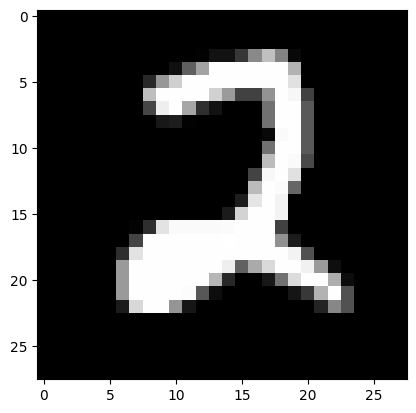

In [127]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)     # img tensor get conv to a batch (basically adds an extra dimension)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

# for a random image
img, label = test_dataset[82]
plt.imshow(img[0], cmap='gray')
print('Predicted:', predict_image(img, model),end='  ')
print('Actual:', label)

### Testing over entire test dataset

In [128]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=batch_size*2, num_workers=4, pin_memory=True), device)
result = evaluate(model, test_loader)
print("Testing loss = {:.4f}, Testing Accuracy = {:.4f}%".format(result['val_loss'], result['val_acc']*100))

Testing loss = 0.0904, Testing Accuracy = 97.3047%


### Save and Upload

In [129]:
saved_weights_fname = 'mnist_weights.pth'
torch.save(model.state_dict(), saved_weights_fname)    # state_dict() returns an ordered dict of all the weights and biases of the model